In [3]:
from PIL import Image, ImageDraw, ImageFont
from lungmask import mask     
import SimpleITK as sitk
import numpy as np
import segmentationtodicomrt as rt
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

In [4]:
def isBoarder(i,j,val,num):
    if num[i,j]==val and sum(sum(num[i-1:i+2,j-1:j+2]==val))<9:
        isBoarder=True
    else:
        isBoarder=False
    return isBoarder

In [5]:
def BorderAlphabet2Numpy(path,file_name,region_number):
    #ds = dicom.read_file(path+'mask/'+file_name, force=True)
    img=Image.open(path+'mask/Text-'+file_name)
    img2 = img.convert("P")
    labeled, nr_objects = ndimage.label(img2) 
    
    num = np.array(labeled)    
    
    
    (bi,bj)=num.shape
    #print(bi,bj)
    # Find Border pixels of each region
    #for region_number in range(2):
    val=region_number
    fi=-1
    fj=-1
    sw=False
    for i in range(bi):
        if sw:
            #print('break')
            break
        for j in range(bj):
            #print(i,j,num[i,j])
            if num[i,j]==val:
                fi=i
                fj=j
                #print(i,j,num[i,j])
                sw=True
                break
    i=fi
    j=fj
    #print(i,j,num[i,j])

    # Create numpy array of borders cordinations 
    meet=np.ones(num.shape)
    li=i
    lj=j
    #meet[i,j]=0
    borders=[]
    a=1
    while a<2000:
        borders.append([i,j])
        i=li
        j=lj
        a=a+1
        #print(a)
        if num[i+1,j]==val and isBoarder(i+1,j,val,num) and meet[i+1,j]:
            li=i+1
            lj=j
            #print(li,lj,num[li,lj])
            meet[li,lj]=0

        elif num[i+1,j+1]==val and isBoarder(i+1,j+1,val,num) and meet[i+1,j+1]:
            li=i+1
            lj=j+1
            #print(li,lj,num[li,lj])
            meet[li,lj]=0
        elif num[i,j+1]==val and isBoarder(i,j+1,val,num)and meet[i,j+1]:
            li=i
            lj=j+1
            #print(li,lj,num[li,lj])
            meet[li,lj]=0
        elif num[i-1,j+1]==val and isBoarder(i-1,j+1,val,num)and meet[i-1,j+1]:
            li=i-1
            lj=j+1
            #print(li,lj,num[li,lj])
            meet[li,lj]=0

        elif num[i-1,j]==val and isBoarder(i-1,j,val,num)and meet[i-1,j]:
            li=i-1
            lj=j
            #print(li,lj,num[li,lj])
            meet[li,lj]=0

        elif num[i+1,j-1]==val and isBoarder(i+1,j-1,val,num)and meet[i+1,j-1]:
            li=i+1
            lj=j-1
            #print(li,lj,num[li,lj])
            meet[li,lj]=0
        elif num[i,j-1]==val and isBoarder(i,j-1,val,num)and meet[i,j-1]:
            li=i
            lj=j-1
            #print(li,lj,num[li,lj])
            meet[li,lj]=0
        elif num[i-1,j-1]==val and isBoarder(i-1,j-1,val,num)and meet[i-1,j-1]:
            li=i-1
            lj=j-1
            #print(li,lj,num[li,lj])
            meet[li,lj]=0
        if (li==i and lj==j):
            [i,j]=borders.pop(-1)
            num[i,j]=val+1
            [i,j]=borders.pop(-1)
            li=i
            lj=j
            #print('------------------------a:',len(borders))
            #print('Del-----',i,j)
        if (fi==li and fj==lj and a>2 ):
            break
            
    borders.append([fi,fj])
    #print('------------------------a:',a)
    # Shapenning borders pixels 
    for t in range(len(borders)):
        #print(t,borders[t])
        i=borders[t][0]
        j=borders[t][1]
        num[i,j]=100

    file_name=file_name.replace('mask-','') 
    file_name=file_name.replace('.png','.dcm')
    np.save(path+ 'borders/Border'+str(val+2)+'-'+file_name +'.npy', borders)
    print('Border'+str(val+2))

In [71]:
# Alphabet image
img = Image.new('RGB', (500, 80), color = (0, 0, 0))
     
fnt = ImageFont.truetype('Arial.ttf', 60) #'/Library/Fonts/'
d = ImageDraw.Draw(img)
d.text((0,0), " Test Dicom RT ", font=fnt, fill=(255, 255, 255))
     
img.save('/Users/Alireza/Desktop/mask/Mask-1.2.826.0.1.3680043.9.3218.1.1.1872364.1022.1591771672055.7043.0-3-45-6lmuab.png')

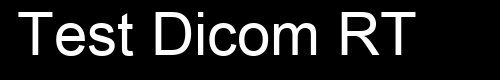

In [72]:
img

(80, 500)
Number of objects is 12


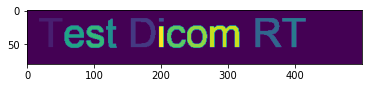

In [83]:

path='/Users/Alireza/Desktop/mask/'
name="Mask-1.2.826.0.1.3680043.9.3218.1.1.1872364.1022.1591771672055.7043.0-3-45-6lmuab.png"

fname=path+name


img = Image.open(fname).convert('L')
img = np.asarray(img)
print(img.shape)

# find connected components
labeled, nr_objects = ndimage.label(img) 
print("Number of objects is {}".format(nr_objects))
# Number of objects is 4 

plt.imshow(labeled)
plt.imsave('/Users/Alireza/Desktop/mask/'+name, labeled)
plt.show()


In [6]:
def Text2Mask(path,name):
    fname=path+'TextImage/'+name

    img = Image.open(fname).convert('L')
    img = np.asarray(img)

    # find connected components
    labeled, nr_objects = ndimage.label(img) 
    
    #print("Number of objects is {}".format(nr_objects))
    # Number of objects is 4 

    plt.imshow(labeled)
    #name=name.replace('.png','.dcm')
    plt.imsave(path+'mask/Text-'+name, labeled)    
    return(nr_objects)

In [7]:
def Text2Image(strText,path,name):
    # Alphabet image
    img = Image.new('RGB', (500, 80), color = (0, 0, 0))

    fnt = ImageFont.truetype('Arial.ttf', 60) #'/Library/Fonts/'
    d = ImageDraw.Draw(img)
    d.text((0,0), strText, font=fnt, fill=(255, 255, 255))

    img.save(path+'TextImage/'+name)

In [1]:
def TextImage2NumpyArray(path):
    import os
    import pydicom as dicom
    from matplotlib import pyplot as plt

    
    files = os.listdir(path+'dicom')
    for i,name in enumerate(files):
        name=files[i]
        if name.find('.dcm')>=0:
            fpath=path+'DICOM/'+name
            ds = dicom.read_file(fpath, force=True)
            print(ds.InstanceNumber)
            strText=' ' + str(ds.InstanceNumber)
            name=name.replace('.dcm','.png')
            Text2Image(strText,path,name)
            nr=Text2Mask(path,name)
            print("Number of objects :",nr)
            for j in range(nr):
                rn=j+1
                print('Boarder number:',rn)
                BorderAlphabet2Numpy(path,name,rn)

5
Number of objects : 1
Boarder number: 1
Border3
126
Number of objects : 3
Boarder number: 1
Border3
Boarder number: 2
Border4
Boarder number: 3
Border5
52
Number of objects : 2
Boarder number: 1
Border3
Boarder number: 2
Border4
60
Number of objects : 2
Boarder number: 1
Border3
Boarder number: 2
Border4
13
Number of objects : 2
Boarder number: 1
Border3
Boarder number: 2
Border4
37
Number of objects : 2
Boarder number: 1
Border3
Boarder number: 2
Border4
45
Number of objects : 2
Boarder number: 1
Border3
Boarder number: 2
Border4
121
Number of objects : 3
Boarder number: 1
Border3
Boarder number: 2
Border4
Boarder number: 3
Border5
50
Number of objects : 2
Boarder number: 1
Border3
Boarder number: 2
Border4
112
Number of objects : 3
Boarder number: 1
Border3
Boarder number: 2
Border4
Boarder number: 3
Border5
79
Number of objects : 2
Boarder number: 1
Border3
Boarder number: 2
Border4
51
Number of objects : 2
Boarder number: 1
Border3
Boarder number: 2
Border4
83
Number of objects :

KeyboardInterrupt: 

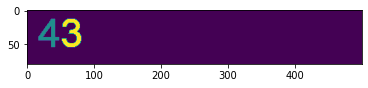

In [12]:
path='/Users/Alireza/Desktop/Datasets/covid4237/'
TextImage2NumpyArray(path)

In [43]:
path+'mask/Text-'+name

'/Users/Alireza/Desktop/Datasets/covid4237/mask/Text-1.2.826.0.1.3680043.9.3218.1.1.1872364.1022.1591771672055.7043.0-3-5-6lk8ut.dcm'

In [41]:
plt.imsave(path+'mask/Text-'+name, labeled)  

KeyError: 'DCM'